# APACHE SPARK CLUSTERING


## Spark Initialization

In [1]:
# Import findspark to read SPARK_HOME and HADOOP_HOME
import findspark
findspark.init()

In [2]:
# Import required library
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

In [3]:
# Print Spark object ID
print(spark)

## Loading Data using Spark

In [4]:
df = spark.read.csv("/Users/gunstringer/Downloads/epa_hap_daily_summary.csv", header=True, inferSchema=True)

In [5]:
df.show()

+----------+-----------+--------+--------------+---+---------+-----------+-------+--------------------+---------------+------------------+-------------------+--------------------+----------+-----------------+-------------------+---------------+---------------+--------------+----+-----------+--------------------+--------------------+--------------------+------------+----------------+-------------+--------------------+-------------------+
|state_code|county_code|site_num|parameter_code|poc| latitude|  longitude|  datum|      parameter_name|sample_duration|pollutant_standard|         date_local|    units_of_measure|event_type|observation_count|observation_percent|arithmetic_mean|first_max_value|first_max_hour| aqi|method_code|         method_name|     local_site_name|             address|  state_name|     county_name|    city_name|           cbsa_name|date_of_last_change|
+----------+-----------+--------+--------------+---+---------+-----------+-------+--------------------+---------------

In [6]:
df.printSchema()

root
 |-- state_code: integer (nullable = true)
 |-- county_code: integer (nullable = true)
 |-- site_num: integer (nullable = true)
 |-- parameter_code: integer (nullable = true)
 |-- poc: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- datum: string (nullable = true)
 |-- parameter_name: string (nullable = true)
 |-- sample_duration: string (nullable = true)
 |-- pollutant_standard: string (nullable = true)
 |-- date_local: timestamp (nullable = true)
 |-- units_of_measure: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- observation_count: integer (nullable = true)
 |-- observation_percent: double (nullable = true)
 |-- arithmetic_mean: double (nullable = true)
 |-- first_max_value: double (nullable = true)
 |-- first_max_hour: integer (nullable = true)
 |-- aqi: string (nullable = true)
 |-- method_code: integer (nullable = true)
 |-- method_name: string (nullable = true)
 |-- local_site_name: st

In [7]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("pollution")

In [8]:
row_count = spark.sql ("SELECT COUNT(1)FROM pollution")

In [9]:
row_count.show()

+--------+
|count(1)|
+--------+
| 8097069|
+--------+



In [10]:
df.count()

8097069

In [11]:
data = spark.sql("SELECT latitude, longitude, parameter_name, arithmetic_mean, state_name FROM pollution")

In [12]:
data.show()

+---------+-----------+--------------------+---------------+------------+
| latitude|  longitude|      parameter_name|arithmetic_mean|  state_name|
+---------+-----------+--------------------+---------------+------------+
|40.445278| -80.420833|    Arsenic PM2.5 LC|          0.003|Pennsylvania|
|32.805818| -97.356568|  Ethylene dibromide|            0.0|       Texas|
|32.057581| -92.435157|       Lead PM2.5 LC|        0.00228|   Louisiana|
| 41.60668| -87.304729|             Benzene|       0.413913|     Indiana|
| 40.53999| -121.57646|     Nickel PM2.5 LC|         1.3E-4|  California|
|42.306674| -83.148754|       Lead PM10 STP|         0.0163|    Michigan|
|34.733889|-120.008349|       Lead PM2.5 LC|            0.0|  California|
|18.425652| -66.115846|     Nickel PM2.5 LC|         0.0127| Puerto Rico|
|38.656498| -90.198646|Acrolein - Unveri...|            0.0|    Missouri|
|37.950741|-121.268523|  Chromium (TSP) STP|          0.003|  California|
|39.340556| -76.582222|cis-13-Dichloro

## Clustering Process
Tahap-tahap yang perlu dilakukan adalah sebagai berikut
### 1. Assembling Vector
Library Spark ML hanya menerima data input dalam bentuk vektor. Oleh karena itu, kita perlu menggabungkan kolom-kolom ke dalam sebuah vektor.
Misal apabila kita memiliki kolom latitude dan longitude yang ingin dijadikan sebagai sebuah input, maka kita harus menjadikannya menjadi [latitude, longitude].
### 2. Train model
Proses training dilakukan dengan memasukkan data latih ke dalam instance dengan mengeset beberapa parameter. Untuk K-Means hanya memerlukan parameter jumlah cluster (k) dan seed (randomness).
### 3. Prediksi
Proses prediksi dilakukan dengan memasukkan data uji ke dalam model yang telah dibuat.
### 4. Evaluasi
Proses evaluasi dilakukan sesuai dengan algoritma yang dipakai. Untuk K-Means evaluasi yang dapat digunakan adalah Silhouette Evaluation.

In [13]:
# assembling vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["latitude", "longitude"],
    outputCol='features')

data = assembler.transform(data)
data.show()

+---------+-----------+--------------------+---------------+------------+--------------------+
| latitude|  longitude|      parameter_name|arithmetic_mean|  state_name|            features|
+---------+-----------+--------------------+---------------+------------+--------------------+
|40.445278| -80.420833|    Arsenic PM2.5 LC|          0.003|Pennsylvania|[40.445278,-80.42...|
|32.805818| -97.356568|  Ethylene dibromide|            0.0|       Texas|[32.805818,-97.35...|
|32.057581| -92.435157|       Lead PM2.5 LC|        0.00228|   Louisiana|[32.057581,-92.43...|
| 41.60668| -87.304729|             Benzene|       0.413913|     Indiana|[41.60668,-87.304...|
| 40.53999| -121.57646|     Nickel PM2.5 LC|         1.3E-4|  California|[40.53999,-121.57...|
|42.306674| -83.148754|       Lead PM10 STP|         0.0163|    Michigan|[42.306674,-83.14...|
|34.733889|-120.008349|       Lead PM2.5 LC|            0.0|  California|[34.733889,-120.0...|
|18.425652| -66.115846|     Nickel PM2.5 LC|      

In [14]:
# train model

# Train model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(10).setSeed(1)
model = kmeans.fit(data)

In [23]:
# Make a prediction
predictions = model.transform(data)
predictions.show(5)

+---------+----------+------------------+---------------+------------+--------------------+----------+
| latitude| longitude|    parameter_name|arithmetic_mean|  state_name|            features|prediction|
+---------+----------+------------------+---------------+------------+--------------------+----------+
|40.445278|-80.420833|  Arsenic PM2.5 LC|          0.003|Pennsylvania|[40.445278,-80.42...|         6|
|32.805818|-97.356568|Ethylene dibromide|            0.0|       Texas|[32.805818,-97.35...|         0|
|32.057581|-92.435157|     Lead PM2.5 LC|        0.00228|   Louisiana|[32.057581,-92.43...|         0|
| 41.60668|-87.304729|           Benzene|       0.413913|     Indiana|[41.60668,-87.304...|         6|
| 40.53999|-121.57646|   Nickel PM2.5 LC|         1.3E-4|  California|[40.53999,-121.57...|         4|
+---------+----------+------------------+---------------+------------+--------------------+----------+
only showing top 5 rows



In [16]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.625198998071943


In [17]:
# Shows the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 31.04103121 -95.55614789]
[  37.71943058 -109.05450872]
[ 41.13987492 -74.40735047]
[  26.62122815 -157.23530063]
[  36.57061666 -119.6290823 ]
[  48.16690446 -124.58056784]
[ 40.84274433 -85.502848  ]
[ 32.14282485 -81.88952483]
[0. 0.]
[ 43.71027892 -94.38379329]


In [20]:
# Visualization using pixiedust
import pixiedust

Table service_connections created successfully


In [21]:
display(predictions)


In [48]:
data2 = spark.sql ("SELECT latitude, longitude, state_name, arithmetic_mean, units_of_measure FROM pollution\
                        WHERE parameter_name = 'Benzene'")
data2.show()

+---------+-----------+-------------+---------------+--------------------+
| latitude|  longitude|   state_name|arithmetic_mean|    units_of_measure|
+---------+-----------+-------------+---------------+--------------------+
| 41.60668| -87.304729|      Indiana|       0.413913|Parts per billion...|
|39.297733| -76.604603|     Maryland|            1.2|Parts per billion...|
| 40.69454|  -73.92769|     New York|            2.5|Parts per billion...|
|41.807776| -71.415105| Rhode Island|          1.962|Parts per billion...|
|37.687526|-121.784217|   California|       1.799496|Parts per billion...|
|29.897516| -93.991084|        Texas|            2.4|Parts per billion...|
|39.758855| -86.115415|      Indiana|       0.143043|Parts per billion...|
|29.716611| -95.222467|        Texas|           6.72|Parts per billion...|
| 33.92086| -116.85841|   California|           1.18|Parts per billion...|
|33.845741| -84.213398|      Georgia|            3.2|Parts per billion...|
|29.706249|  -95.26113|  

In [49]:
data2.count()

469375

In [50]:
assembler = VectorAssembler(
    inputCols=["arithmetic_mean"],
    outputCol='features')

data2 = assembler.transform(data2)
data2.show()

+---------+-----------+-------------+---------------+--------------------+----------+
| latitude|  longitude|   state_name|arithmetic_mean|    units_of_measure|  features|
+---------+-----------+-------------+---------------+--------------------+----------+
| 41.60668| -87.304729|      Indiana|       0.413913|Parts per billion...|[0.413913]|
|39.297733| -76.604603|     Maryland|            1.2|Parts per billion...|     [1.2]|
| 40.69454|  -73.92769|     New York|            2.5|Parts per billion...|     [2.5]|
|41.807776| -71.415105| Rhode Island|          1.962|Parts per billion...|   [1.962]|
|37.687526|-121.784217|   California|       1.799496|Parts per billion...|[1.799496]|
|29.897516| -93.991084|        Texas|            2.4|Parts per billion...|     [2.4]|
|39.758855| -86.115415|      Indiana|       0.143043|Parts per billion...|[0.143043]|
|29.716611| -95.222467|        Texas|           6.72|Parts per billion...|    [6.72]|
| 33.92086| -116.85841|   California|           1.18|P

In [51]:
kmeans = KMeans().setK(10).setSeed(1)
model = kmeans.fit(data2)

In [52]:
# Make a prediction
predictions2 = model.transform(data2)
predictions2.show(5)

+---------+-----------+------------+---------------+--------------------+----------+----------+
| latitude|  longitude|  state_name|arithmetic_mean|    units_of_measure|  features|prediction|
+---------+-----------+------------+---------------+--------------------+----------+----------+
| 41.60668| -87.304729|     Indiana|       0.413913|Parts per billion...|[0.413913]|         0|
|39.297733| -76.604603|    Maryland|            1.2|Parts per billion...|     [1.2]|         0|
| 40.69454|  -73.92769|    New York|            2.5|Parts per billion...|     [2.5]|         8|
|41.807776| -71.415105|Rhode Island|          1.962|Parts per billion...|   [1.962]|         0|
|37.687526|-121.784217|  California|       1.799496|Parts per billion...|[1.799496]|         0|
+---------+-----------+------------+---------------+--------------------+----------+----------+
only showing top 5 rows



In [59]:
# Register the DataFrame as a SQL temporary view
predictions2.createOrReplaceTempView("predictions2")
query2 = spark.sql("SELECT AVG(latitude), AVG(longitude),state_name, AVG(arithmetic_mean) from predictions2\
                   group by state_name\
                   order by avg(arithmetic_mean) DESC");
query2.show()

+------------------+-------------------+-----------------+--------------------+
|     avg(latitude)|     avg(longitude)|       state_name|avg(arithmetic_mean)|
+------------------+-------------------+-----------------+--------------------+
| 32.21014712278483|-112.96015111772151|Country Of Mexico|   8.708797468354431|
| 32.87814593933739| -87.06866805926266|          Alabama|   6.430967802146523|
| 38.48754786792453| -95.83892935849056|           Kansas|   5.406358490566038|
|61.205861000000006|        -149.824602|           Alaska|   4.649691056910569|
|35.311346510971795|-106.84987212225704|       New Mexico|  4.2419974639498434|
|38.628729420659546| -90.19782182825128|         Missouri|  4.0470664072806475|
| 39.54561878118746|-106.96211211229695|         Colorado|   3.530716491661107|
| 33.44295241512177|-111.95875111741199|          Arizona|  3.2813660599781884|
|30.588670533176707| -97.46160633335236|            Texas|   3.165615802749503|
| 34.26485022727273| -92.66971016666668|

In [60]:
query2.count()

51

In [62]:
assembler = VectorAssembler(
    inputCols=["avg(arithmetic_mean)"],
    outputCol='features')

data3 = assembler.transform(query2)
data3.show()

+------------------+-------------------+-----------------+--------------------+--------------------+
|     avg(latitude)|     avg(longitude)|       state_name|avg(arithmetic_mean)|            features|
+------------------+-------------------+-----------------+--------------------+--------------------+
| 32.21014712278483|-112.96015111772151|Country Of Mexico|   8.708797468354431| [8.708797468354431]|
| 32.87814593933739| -87.06866805926266|          Alabama|   6.430967802146523| [6.430967802146523]|
| 38.48754786792453| -95.83892935849056|           Kansas|   5.406358490566038| [5.406358490566038]|
|61.205861000000006|        -149.824602|           Alaska|   4.649691056910569| [4.649691056910569]|
|35.311346510971795|-106.84987212225704|       New Mexico|  4.2419974639498434|[4.2419974639498434]|
|38.628729420659546| -90.19782182825128|         Missouri|  4.0470664072806475|[4.0470664072806475]|
| 39.54561878118746|-106.96211211229695|         Colorado|   3.530716491661107| [3.53071649

In [63]:
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(data3)

In [64]:
# Shows the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[1.94475887]
[8.70879747]
[4.71779962]


In [65]:
predictions3 = model.transform(data3)
predictions3.show(5)

+------------------+-------------------+-----------------+--------------------+--------------------+----------+
|     avg(latitude)|     avg(longitude)|       state_name|avg(arithmetic_mean)|            features|prediction|
+------------------+-------------------+-----------------+--------------------+--------------------+----------+
| 32.21014712278483|-112.96015111772151|Country Of Mexico|   8.708797468354431| [8.708797468354431]|         1|
| 32.87814593933739| -87.06866805926266|          Alabama|   6.430967802146523| [6.430967802146523]|         2|
| 38.48754786792453| -95.83892935849056|           Kansas|   5.406358490566038| [5.406358490566038]|         2|
|61.205861000000006|        -149.824602|           Alaska|   4.649691056910569| [4.649691056910569]|         2|
|35.311346510971795|-106.84987212225704|       New Mexico|  4.2419974639498434|[4.2419974639498434]|         2|
+------------------+-------------------+-----------------+--------------------+--------------------+----

In [66]:
display(predictions3)


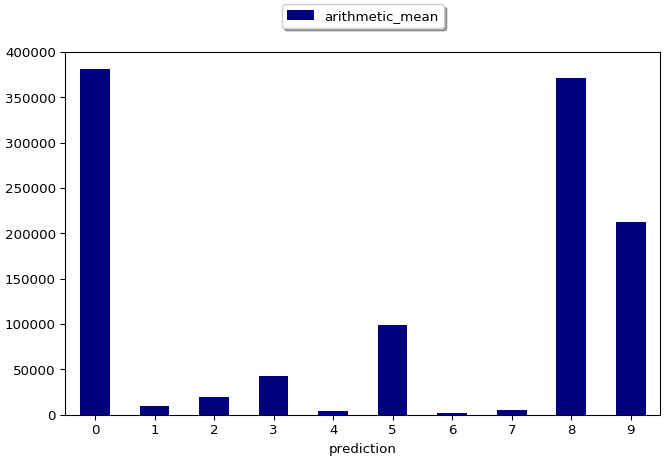

In [53]:
display(predictions2)